In [4]:
from __future__ import division
from scipy.optimize import curve_fit
from pylab import *
%matplotlib inline

This note book is for simulation of Gaussian optics in simple lens setups for beam shaping. For use in the case where simple formula $$w^\prime=\frac{\lambda f}{\pi w}$$ is insufficent, i.e. where $f\sim z_r$ and/or the beam is highly elliptical/astigmatic.


#### Constant Parameters

All dimensions are scaled to millimeters (keep in mind when specifying waists and focal length)

Make sure you put in your wavelength here!)

In [5]:
mm=1e-3
lam=852e-9/mm #wavelength

#### Basic Functions

Function for propegation of Gaussian beam by ABCD matrix method.  See Yariv Quanutum Electronics, or Siegmann Lasers for textbook treatment

In [67]:
def zr(waist):
    #rayleigh range
    return pi*waist**2/lam
def waistz0(lam,z0):
    return np.sqrt(lam*z0/np.pi)
def waistz(z,z0,w0):
    #beam waist as function of z
    return w0*sqrt(1+((z-z0)/zr(w0))**2)
def radiusz(z,z0,w0):
    #beam radius of curvature as function of z
    return (z-z0)*(1+((z-z0)/zr(w0))**2)
def q0(w0):
    #q parameter at waist
    return 1j*pi*w0**2/lam
def wfromq(q):
    #convert q back to waist values
    return sqrt(-1*lam/(pi*imag(1/q)))
def propd(q,d):
    #propegaction of q by distance d
    return q+d
def lensf(q,f):
    #action of lens of focal lens f on q
    return q/(-q/f+1)
def qz(z,z0,w0):
    #q parameter at z given w0 at z0
    return propd(q0(w0),z-z0)

In [70]:
waistz0(lam,458)
waistz(300,0,0.35)

0.4201622691796022

#### Find waist from two point measurement

Assume we measure the waist $w_1$ at $z=z_1=0$ and $w_2$ at $z=z_2$, find the location and value of the waist, $z_0,w_0$ (for both x and y)

In [7]:
def findwaist(w1,w2,z2):
    zdata=array([0,z2])
    wdata=array([w1,w2])
    #curvefit to waist function using p0=[z0,w0] as initial parameters
    if w1>w2: #if focusing, using second waist as initial parameters
        [z0,w0]=[2*z2,w2/2.]
    else: #if diverging, use first waist
        [z0,w0]=[-z2,w1/2.]
    popt, pcov = curve_fit(waistz,zdata,wdata,p0=[z0,w0])
    return popt #return fit paramers [z0,w0]

x: z0=-436.90 mm and w0=0.202 mm
y: z0=-473.79 mm and w0=0.209 mm


c:\Users\yuanhang.yang\Anaconda3\envs\SPB_test\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


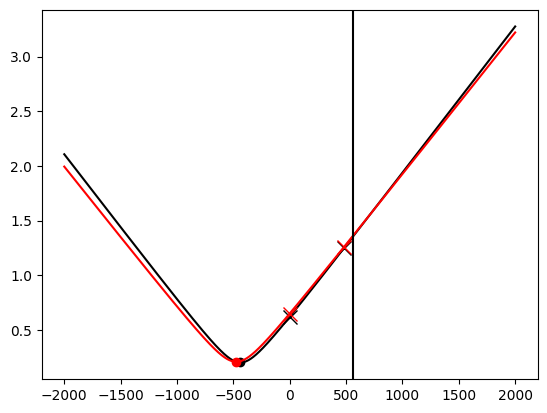

In [47]:
#measured values: (assumes z1=0)

#x
[xw1,xw2,xz2]=[.62,1.25,482.6] #measured values
[xz0,xw0] = findwaist(xw1,xw2,xz2)
print("x: z0=%0.2f mm and w0=%0.3f mm" %(xz0,xw0))
#y
[yw1,yw2,yz2]=[0.65,1.26,482.6] #measured values
[yz0,yw0] = findwaist(yw1,yw2,yz2)
print("y: z0=%0.2f mm and w0=%0.3f mm" %(yz0,yw0))
#[.504,.598,475]


max_dist = 2000 #total propegaction distance in mm
Nsteps = 5000
zlist = linspace(-max_dist,max_dist,Nsteps)
plot(0,xw1,'kx',markersize=10)
plot(xz2,xw2,'kx',markersize=10)
plot(xz0,xw0,'ko')

plot(zlist,waistz(zlist,xz0,xw0),'k')
plot(0,yw1,'rx',markersize=10)
plot(yz2,yw2,'rx',markersize=10)
plot(yz0,yw0,'ro')
plot(zlist,waistz(zlist,yz0,yw0),'r')
plt.axvline(x=22*25.4,color='k')




#### Set up beam propegation:

In [23]:
#inital q parameters at z=0 for x and y (using waist locations determerined above)
qx0 = qz(0,xz0,xw0)
qy0 = qz(0,yz0,yw0)
#qx0 = q0(1.7)
#qy0 = q0(1.7)
print(qx0)
print(qy0)

max_dist = 1400 #total propegaction distance in mm
Nsteps = 500
zlist = linspace(0,max_dist,Nsteps)
stepsize = zlist[1] - zlist[0]
q = 1j*zeros((2,Nsteps)) #top row is for x and bottom row is y
q[:,0] = [qx0,qy0] #set inital parameters


(436.89814550917913+150.68897445613342j)
(473.7909685820203+160.6590246624886j)


###Check Propegation without lenses:

(0.0, 3.0)

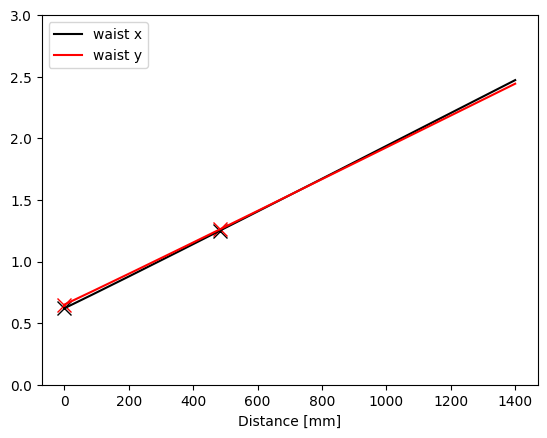

In [24]:
for i,z in enumerate(zlist[1:]):
    q[0,i+1]=propd(q[0,i],stepsize)
    q[1,i+1]=propd(q[1,i],stepsize)
wx=wfromq(q[0,:])
wy=wfromq(q[1,:])

plot(0,xw1,'kx',markersize=10)
plot(xz2,xw2,'kx',markersize=10)
plot(0,yw1,'rx',markersize=10)
plot(yz2,yw2,'rx',markersize=10)


plot(zlist,wx,'k',label='waist x')
plot(zlist,wy,'r',label='waist y')
xlabel('Distance [mm]')
legend(loc=2)
plt.ylim(0,3.)

0 1.0 54.04
0.8313089813201798
0.7506354609371229


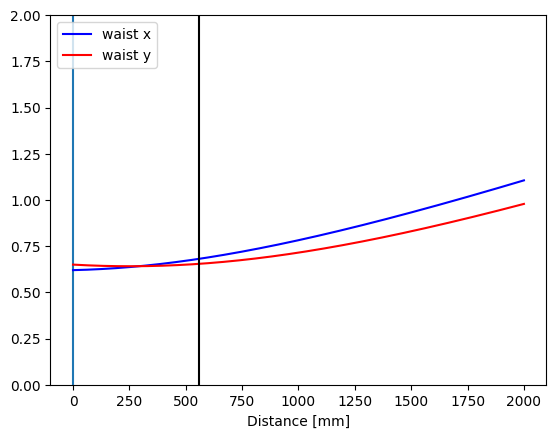

In [50]:
max_dist = 2000 #total propegaction distance in mm
Nsteps = 2000
zlist = linspace(0,max_dist,Nsteps)
stepsize = zlist[1] - zlist[0]
q = 1j*zeros((2,Nsteps)) #top row is for x and bottom row is y
q[:,0] = [qx0,qy0] #set inital parameters

#denfine lenses [z,fx,fy]
finf=10e6 #effective infinite focal length for cylindiral lenses, using 'inf' causes an error

f1=500.
f2=750.
p0 =1
lens1=[p0,f1,f1]
lens2=[300,f2,f2]

lenses=array([lens1])

for i,z in enumerate(zlist[1:]):
    for j in range(len(lenses[:,0])): #loop over lenses
        if abs(z-lenses[j,0])<stepsize/2: #if less than half step size from lens location, apply to q
            q[0,i]=lensf(q[0,i],lenses[j,1])
            q[1,i]=lensf(q[1,i],lenses[j,2])
            print(j,lenses[j,0],lenses[j,0]/25.+54)
            plt.axvline(x=lenses[j,0])
    q[0,i+1]=propd(q[0,i],stepsize)
    q[1,i+1]=propd(q[1,i],stepsize)
    
wx=wfromq(q[0,:])
wy=wfromq(q[1,:])

plot(zlist,wx,'b',label='waist x',)
plot(zlist,wy,'r',label='waist y')
xlabel('Distance [mm]')
legend(loc=2)
ylim(0,2)
plt.axvline(x=22*25.4,color='k')

print(wx[1175])
print(wy[1175])

### Simulation including both x and y dimension

Include Lenses, a three lens telescope to collemate the beam to a round spot, forth lens to focus to doubling cavity

0 1.0 54.04
1 125.0 59.0
0.45716814616227364
0.4488073379440611


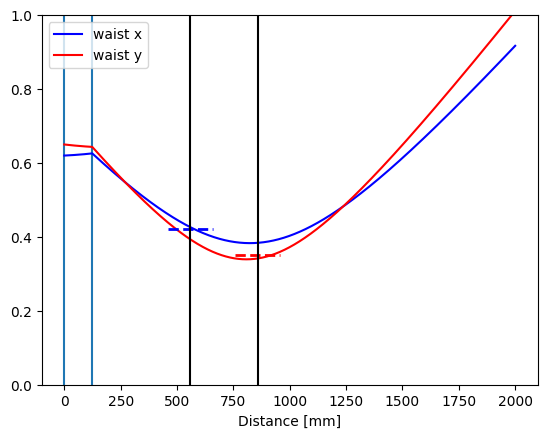

In [73]:
max_dist = 2000 #total propegaction distance in mm
Nsteps = 2000
zlist = linspace(0,max_dist,Nsteps)
stepsize = zlist[1] - zlist[0]
q = 1j*zeros((2,Nsteps)) #top row is for x and bottom row is y
q[:,0] = [qx0,qy0] #set inital parameters

#denfine lenses [z,fx,fy]
finf=10e6 #effective infinite focal length for cylindiral lenses, using 'inf' causes an error

f1=500.
f2=1000.
p0 =1
lens1=[p0,f1,f1]
lens2=[125,f2,f2]

lenses=array([lens1,lens2])

for i,z in enumerate(zlist[1:]):
    for j in range(len(lenses[:,0])): #loop over lenses
        if abs(z-lenses[j,0])<stepsize/2: #if less than half step size from lens location, apply to q
            q[0,i]=lensf(q[0,i],lenses[j,1])
            q[1,i]=lensf(q[1,i],lenses[j,2])
            print(j,lenses[j,0],lenses[j,0]/25.+54)
            plt.axvline(x=lenses[j,0])
    q[0,i+1]=propd(q[0,i],stepsize)
    q[1,i+1]=propd(q[1,i],stepsize)
    
wx=wfromq(q[0,:])
wy=wfromq(q[1,:])

plot(zlist,wx,'b',label='waist x',)
plot(zlist,wy,'r',label='waist y')
xlabel('Distance [mm]')
legend(loc=2)
ylim(0,1)
plot([22*25.4-100, 22*25.4+100], [.42, .42],'b--', linewidth=2)#x target waist
plot([22*25.4+200, 22*25.4+400], [.35, .35],'r--', linewidth=2)#y target waist
plt.axvline(x=22*25.4,color='k')
plt.axvline(x=22*25.4+300,color='k')

print(wx[1175])
print(wy[1175])

In [32]:
24*25.4

609.5999999999999

(0.0, 1.0)

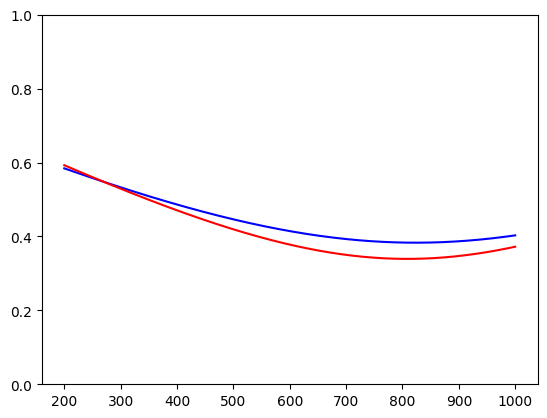

In [65]:
ztlist = linspace(200,1000,800)
plot(ztlist, wx[200:1000], 'b')
plot(ztlist, wy[200:1000], 'r')
ylim(0,1)

### Beam Propegation for a circular beam

In [10]:
#inital q parameter at z=0 
qi0 = q0(0.670)  # initial waist
print(qi0)

max_dist = 1500 #total propegaction distance in mm
Nsteps = 1000
zlist = linspace(0,max_dist,Nsteps)
stepsize = zlist[1] - zlist[0]
q = 1j*zeros(Nsteps) #empty complex array
q[0] = qi0 #set inital parameters

2011.784510979256j


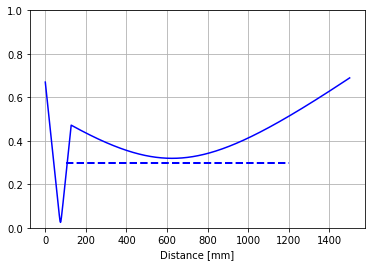

In [11]:
q[0] = qi0 #set inital parameters
#denfine lenses [z,f] in mm
lens1=[1,75.0]
lens2=[1+75+53.5,50.0]
lenses=array([lens1,lens2])

for i,z in enumerate(zlist[1:]):
    for j in range(len(lenses[:,0])): #loop over lenses
        if abs(z-lenses[j,0])<stepsize/2: #if less than half step size from lens location, apply to q
            q[i]=lensf(q[i],lenses[j,1])
            #print j
    q[i+1]=propd(q[i],stepsize)
    
wx=wfromq(q[:])
plot(zlist,wx,'b',label='waist x',)
plt.grid()
xlabel('Distance [mm]')
ylim(0,1)
plot([100, 1200], [.300, .300],'b--', linewidth=2)#x target waist